# 1.086 Wake modeling demo with FLORIS

This is ademonstration notebook for wake modeling in NREL's FLORIS (FLOw Redirection In Steady state) tool. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

from floris.tools import FlorisInterface
import floris.tools.visualization as wakeviz
from floris.tools.visualization import visualize_cut_plane

import setup_windfarm, figuresettings

FIGPATH = Path('../figs')
FIGPATH.mkdir(parents=True, exist_ok=True)

Begin with a single wind turbine wind farm: 

In [30]:
fi = setup_windfarm.farm(rows=1, cols=1, wd_array=[270]) #[255, 270, 285])
fi_jensen = setup_windfarm.farm(rows=1, cols=1, wd_array=[270], velocity_model='Jensen') 

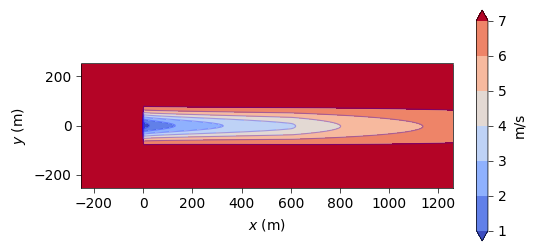

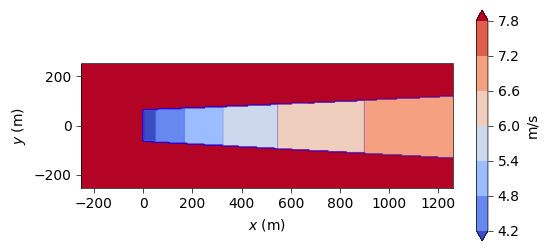

In [31]:
for _fi, name in zip([fi, fi_jensen], ['Gauss', 'Jensen']): 
    horizontal_plane = _fi.calculate_horizontal_plane(
        x_resolution=256,
        y_resolution=128,
        height=90.0,
    )

    fig, ax = plt.subplots(figsize=(6, 3))
    wakeviz.visualize_cut_plane(horizontal_plane, ax=ax, color_bar=True)
    ax.set_xlabel('$x$ (m)')
    ax.set_ylabel('$y$ (m)')
    plt.savefig(FIGPATH / f'single_turbine_270_{name:s}.png')
    plt.show()

Let's stick with the Gaussian wake model and run a larger wind farm. 

We will consider multiple wind directions for a couple different wind farm layouts. 

In [32]:
fi = setup_windfarm.farm(Sx=6, Sy=6, rows=6, cols=6, wd_array=[270], ws_array=[12])

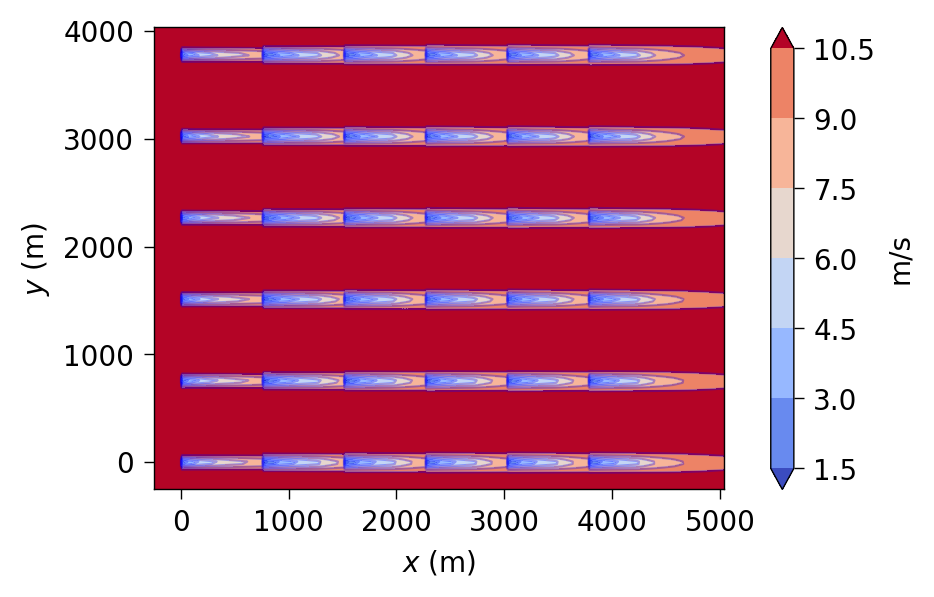

In [33]:
# plot just one wind direction initially
horizontal_plane = fi.calculate_horizontal_plane(
    x_resolution=400,
    y_resolution=200,
    height=90.0,
    # yaw_angles=,
)

fig, ax = plt.subplots(figsize=(6, 3), dpi=200)
wakeviz.visualize_cut_plane(horizontal_plane, ax=ax, color_bar=True)
ax.set_xlabel('$x$ (m)')
ax.set_ylabel('$y$ (m)')

plt.show()

Let's plot just the turbine powers because wake visualization takes a while and is only qualitative

In [126]:
# Visualize turbine power production
def contour_power(turbine_powers, ax=None, rows=6, cols=6, cmap='viridis', agg=np.mean, normfact=None):
    if ax is None: 
        _, ax = plt.subplots()

    power_avg = agg(turbine_powers, axis=(0, 1)).reshape(rows, cols)
    extent = [0.5, rows+0.5, 0.5, cols+0.5]
    im = ax.imshow(power_avg.T, origin='lower', extent=extent, cmap=cmap)

    # Custom grid
    ax.set_xticks([x+0.5 for x in range(0,rows)], minor=True)
    ax.set_yticks([y+0.5 for y in range(0,cols)], minor=True)

    # plot grid on minor axes
    plt.grid(which="minor",ls="-",lw=1)

    if normfact is None: 
        normfact = np.max(turbine_powers)  # somewhere in here there will be a freestream turbine
    
    eff = np.mean(power_avg) / normfact  # array efficiency

    ax.set_title(f'Array efficiency: {eff * 100:.1f}%')
    ax.set_xlabel('Turbine row')
    ax.set_ylabel('Turbine column')

    return im, ax


In [35]:
fi.calculate_wake()
turbine_powers = fi.get_turbine_powers() / 1E3 # In kW


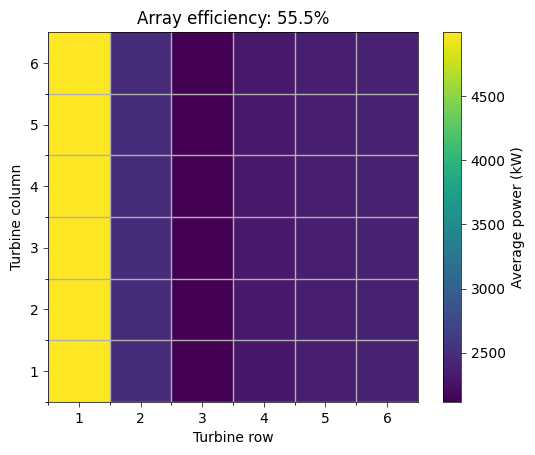

In [36]:

im, ax = contour_power(turbine_powers)
plt.colorbar(im, label='Average power (kW)')
plt.show()

In [37]:
winddir_all = np.arange(0, 360, 1)
fi.reinitialize(wind_directions=winddir_all)

fi.calculate_wake()
turbine_powers = fi.get_turbine_powers() / 1e3

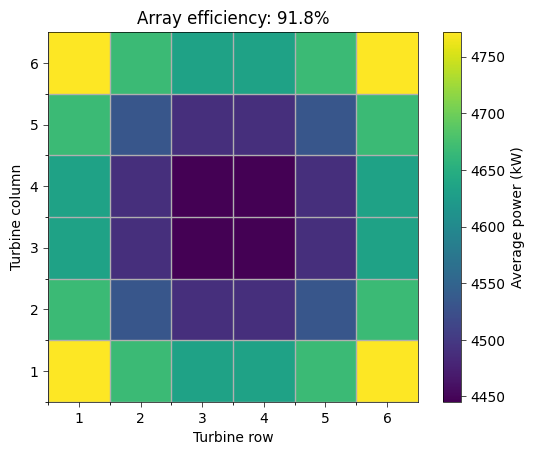

In [38]:
im, ax = contour_power(turbine_powers)
plt.colorbar(im, label='Average power (kW)')
plt.show()

Often times, this is plotted with power on the vertical axis and wind direction on the horizontal: 


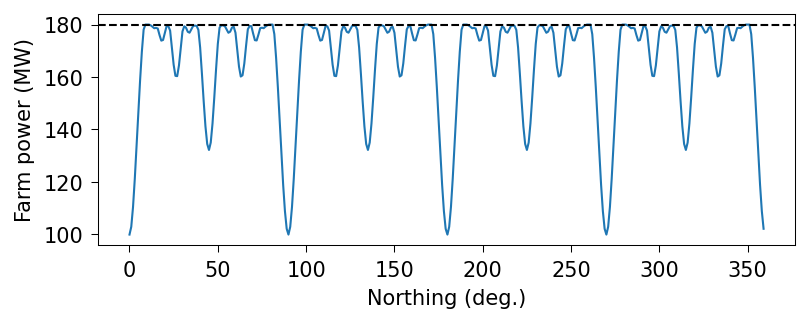

In [39]:
fig, ax = plt.subplots(dpi=150, figsize=(6, 2))
ax.plot(winddir_all, np.sum(turbine_powers, axis=2).squeeze() / 1e3)
ax.set_xlabel('Northing (deg.)')
ax.set_ylabel('Farm power (MW)')

N_turbines = 36
power_no_losses = np.max(turbine_powers) * N_turbines / 1e3
ax.axhline(power_no_losses, color='k', ls='--', lw=1.)

plt.show()

## Let's add in "realistic" wind rose

Correcting negative Overhang:-2.5
Correcting negative Overhang:-7.5


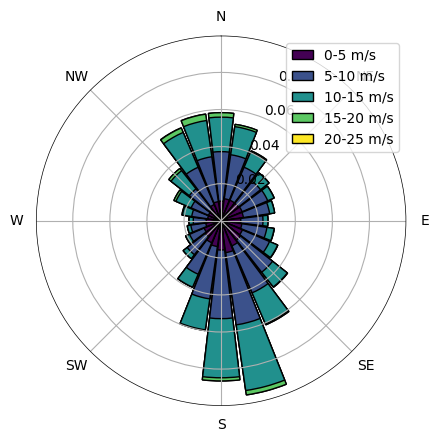

In [12]:
import pandas as pd
from floris.tools.wind_rose import WindRose

rose = WindRose()
rose.read_wind_rose_csv('./inputs/wind_rose.csv')
rose.plot_wind_rose()
plt.show()

For each frequency, let's compute the power of the wind farm

In [87]:
fi = setup_windfarm.farm(Sx=6, Sy=6)  # make a new wind farm setup

fi.reinitialize(
    wind_speeds=[10],  # just one wind speed, for now
    wind_directions=rose.df['wd'].unique(), 
)

fi.calculate_wake()
turbine_power_rose = fi.get_turbine_powers() / 1e3  # in kW

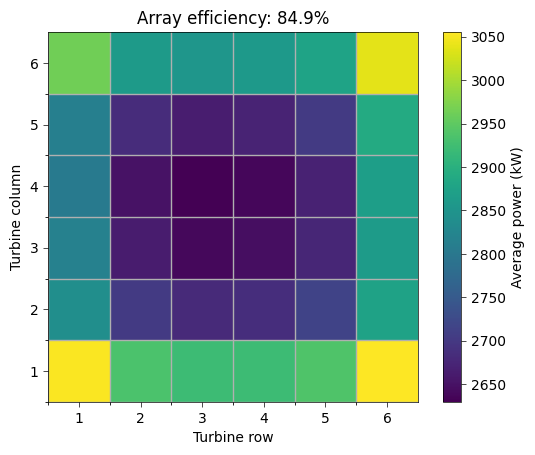

In [88]:
# compute the average turbine powers, but now perform a weighted
# average over the frequency bins
frequencies = rose.df.groupby('wd').sum()
turbine_power_weighted = turbine_power_rose * frequencies['freq_val'].values[:, None, None]
im, ax = contour_power(turbine_power_weighted, agg=np.sum, normfact=np.max(turbine_power_rose))
plt.colorbar(im, label='Average power (kW)')
plt.show()

Repeat for a wind farm with asymmetric turbine spacing: 

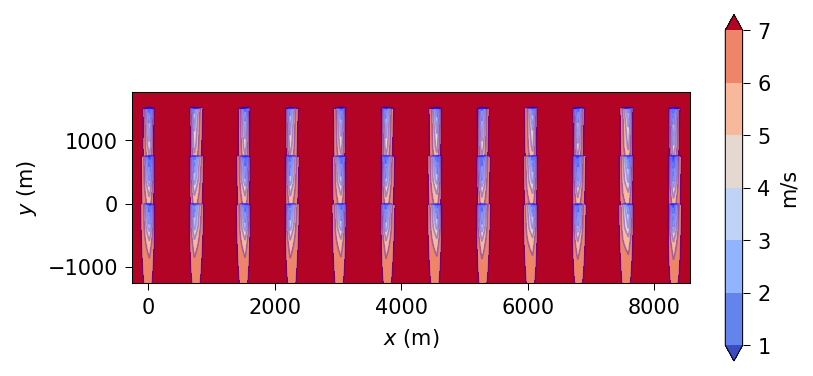

In [132]:
fi_oblique = setup_windfarm.farm(Sx=6, Sy=6, rows=12, cols=3, wd_array=[0])

horizontal_plane = fi_oblique.calculate_horizontal_plane(
    x_resolution=200,
    y_resolution=100,
    height=90.0,
    # yaw_angles=,
)
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
wakeviz.visualize_cut_plane(horizontal_plane, ax=ax, color_bar=True)

ax.set_xlabel('$x$ (m)')
ax.set_ylabel('$y$ (m)')

plt.show()

In [130]:
fi_oblique.reinitialize(
    wind_speeds=[10],  # just one wind speed, for now
    wind_directions=rose.df['wd'].unique(), 
)

fi_oblique.calculate_wake()
turbine_power_oblique = fi_oblique.get_turbine_powers() / 1e3  # 


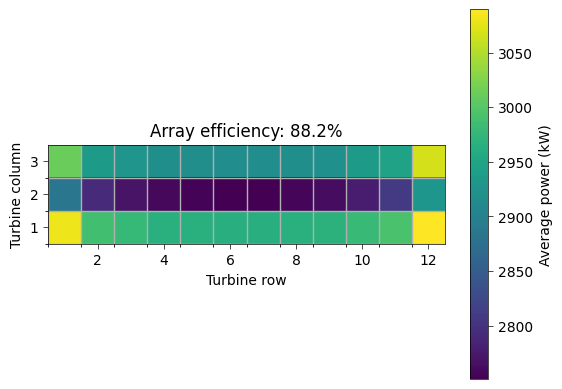

In [131]:
# compute the average turbine powers, but now perform a weighted
# average over the frequency bins
frequencies = rose.df.groupby('wd').sum()
turbine_weighted_oblique = turbine_power_oblique * frequencies['freq_val'].values[:, None, None]
im, ax = contour_power(turbine_weighted_oblique, agg=np.sum, normfact=np.max(turbine_power_oblique), rows=12, cols=3)
plt.colorbar(im, label='Average power (kW)')
plt.show()

## Effect of changing turbulence intensity

In [20]:
fi = setup_windfarm.farm(Sx=6, Sy=6, rows=6, cols=6, wd_array=winddir_all, ws_array=[12])
fi.calculate_wake()
power_ti_low = fi.get_turbine_powers()

fi.reinitialize(turbulence_intensity=0.20)
fi.calculate_wake()
power_ti_high = fi.get_turbine_powers()


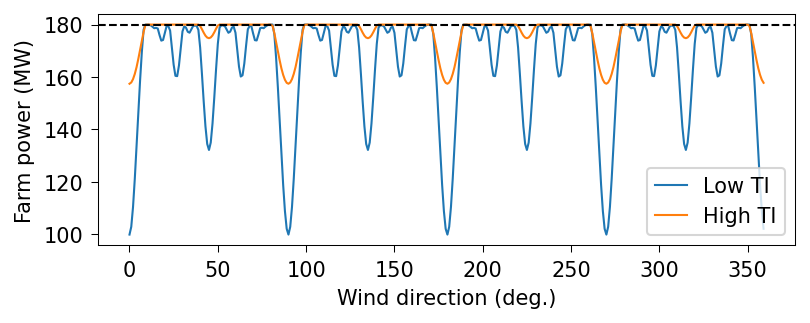

In [21]:
fig, ax = plt.subplots(dpi=150, figsize=(6, 2))
ax.plot(winddir_all, np.sum(power_ti_low, axis=2).squeeze() / 1e6, label='Low TI')
ax.plot(winddir_all, np.sum(power_ti_high, axis=2).squeeze() / 1e6, label='High TI')
ax.set_xlabel('Wind direction (deg.)')
ax.set_ylabel('Farm power (MW)')

N_turbines = 36
power_no_losses = np.max(turbine_powers) * N_turbines / 1e3
ax.axhline(power_no_losses, color='k', ls='--', lw=1.)
ax.legend()

plt.show()

Visualize wakes as well: 

In [22]:
fi.reinitialize(wind_directions=[270])

horizontal_plane = fi.calculate_horizontal_plane(
    x_resolution=200,
    y_resolution=100,
    height=90.0,
    # yaw_angles=,
)

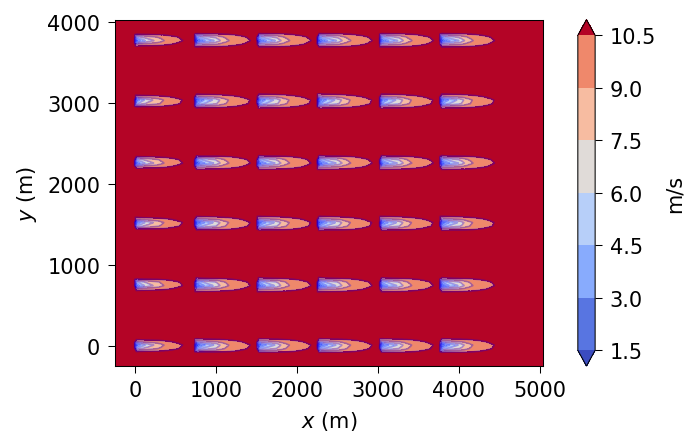

In [23]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
wakeviz.visualize_cut_plane(horizontal_plane, ax=ax, color_bar=True)

ax.set_xlabel('$x$ (m)')
ax.set_ylabel('$y$ (m)')

plt.show()